이 커널은 https://www.kaggle.com/tmheo74/3rd-ml-month-car-image-cropping-updated-7-10 을 필사하면서 공부한 커널입니다.

# Image Preprocessing - Crop

안녕하세요. 캐코 3회 대회는 자동차 이미지 분류 문제인데요.

제공되는 데이터를 보면 이미지에 자동차 외에 배경도 포함되어 있는 것을 볼 수 있습니다.

이미지에서 이런 배경 부분을 없애고 자동차 부분만 모델 트레이닝 하는데 사용한다면 더 좋은 성능을 얻을 수 있을거라 생각되는데요.

대회 운영진인 김태진님이 공유한 아래의 베이스라인 커널은 제공되는 이미지를 그대로 사용하고 있지만, 바운딩 박스 처리에 대한 언급을 하셨습니다.

https://www.kaggle.com/fulrose/3rd-ml-month-car-model-classification-baseline

그래서 본 커널에서는 데이터에서 제공되는 바운딩 박스를 기준으로 이미지를 잘라 저장해서, 이 데이터를 모델에 사용할 수 있도록 하겠습니다.

대부분의 코드는 김태진님이 공유한 커널을 바탕으로 했습니다.

# Cropped Image Dataset

본 커널에서 생성한 Crop 이미지 데이터는 아래 링크의 Kaggle Dataset으로 만들었으니 자유롭게 사용하시면 됩니다.

https://www.kaggle.com/tmheo74/3rd-ml-month-car-image-cropping-dataset

In [16]:
import gc
import os
import glob
import zipfile
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
import PIL
from PIL import ImageOps, ImageFilter, ImageDraw

In [17]:
DATA_PATH = '../input/'
os.listdir(DATA_PATH)

['test',
 'class.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'train']

In [18]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

In [19]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [20]:
df_test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


In [21]:
def crop_boxing_img(img_name, margin=16) :
    if img_name.split('_')[0] == "train" :
        PATH = TRAIN_IMG_PATH
        data = df_train
    elif img_name.split('_')[0] == "test" :
        PATH = TEST_IMG_PATH
        data = df_test
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)
    
    if abs(pos[2] - pos[0]) > width or abs(pos[3] - pos[1]) > height:
        print(f'{img_name} is wrong bounding box, img size: {img.size},  bbox_x1: {pos[0]}, bbox_x2: {pos[2]}, bbox_y1: {pos[1]}, bbox_y2: {pos[3]}')
        return img

    return img.crop((x1,y1,x2,y2))

# Process Train Image Data Crop

In [22]:
for i, row in df_train.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(row['img_file'])

# Process Test Image Data Crop

In [23]:
for i, row in df_test.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(row['img_file'])

# Cropped Image Eye Checking

## Train Data

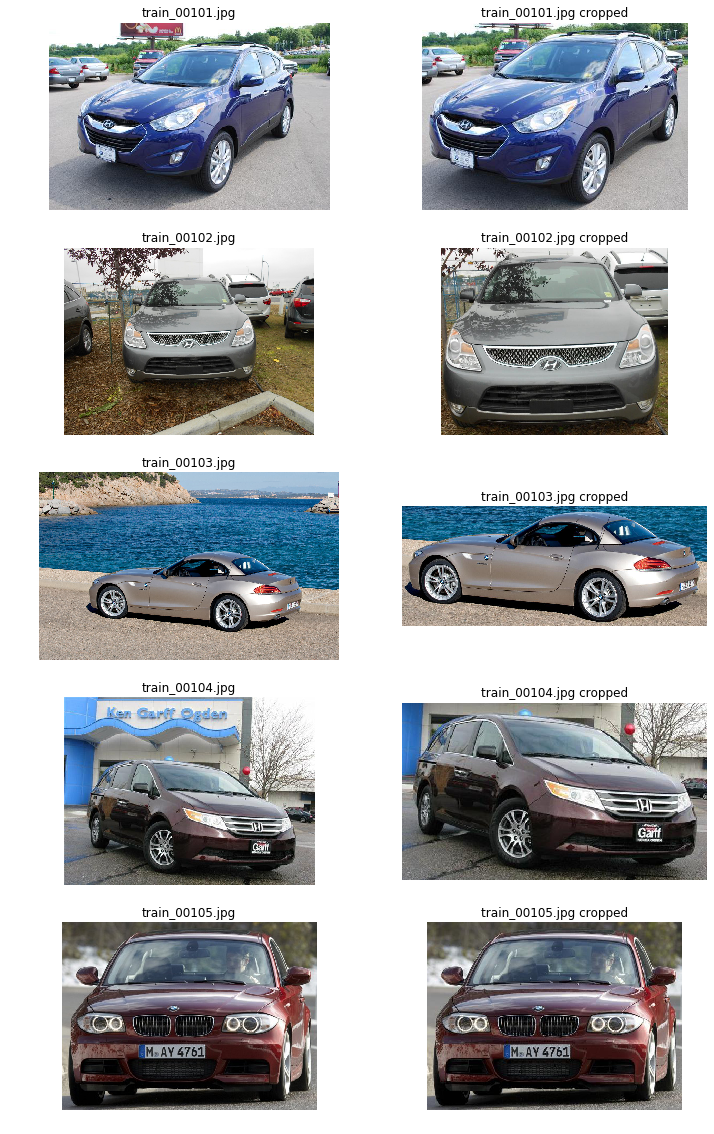

In [24]:
tmp_imgs = df_train['img_file'][100:105]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, 2*num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')
    
    img_crop = PIL.Image.open(f_name)
    plt.subplot(5, 2, 2*num + 2)
    plt.title(f_name + ' cropped')
    plt.imshow(img_crop)
    plt.axis('off')

## Test Data

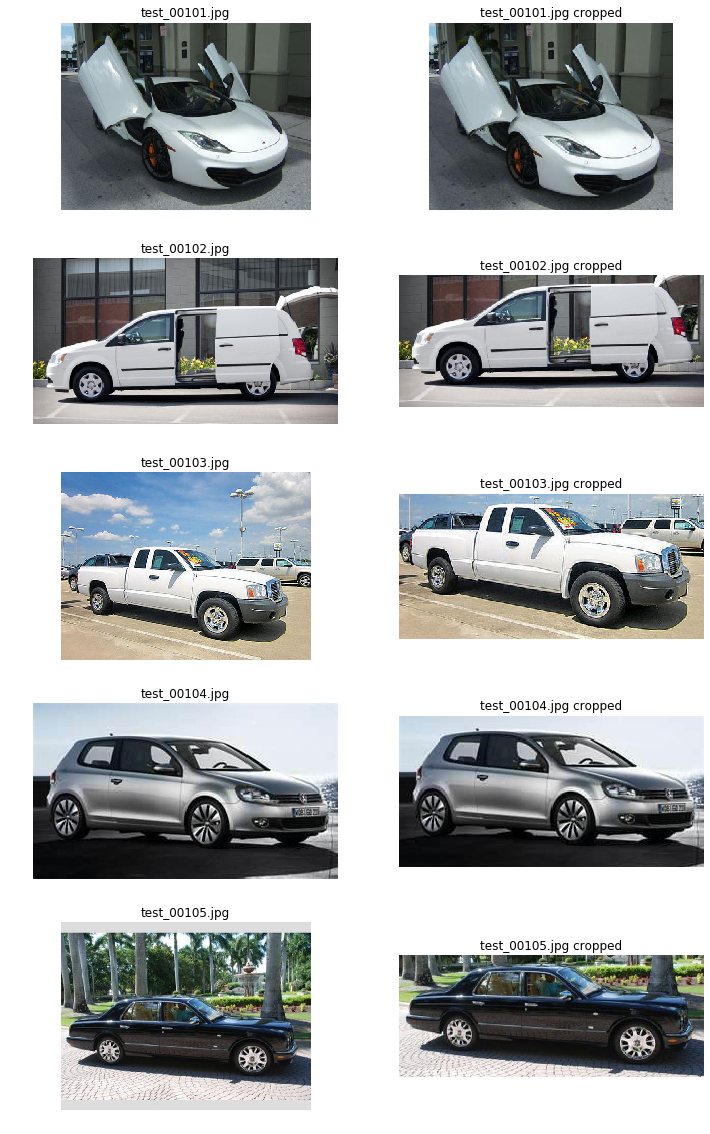

In [25]:
tmp_imgs = df_test['img_file'][100:105]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TEST_IMG_PATH, f_name))
    plt.subplot(5, 2, 2*num+1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')
    
    img_crop = PIL.Image.open(f_name)
    plt.subplot(5, 2, 2*num+2)
    plt.title(f_name + ' cropped')
    plt.imshow(img_crop)
    plt.axis('off')

# Zip Train, Test Image

In [27]:
with zipfile.ZipFile('train_crop.zip', 'w') as zip:
        # writing each file one by one
        for file in glob.glob('train*.jpg'):
            zip.write(file)

In [28]:
with zipfile.ZipFile('test_crop.zip','w') as zip: 
        # writing each file one by one 
        for file in glob.glob('test*.jpg'): 
            zip.write(file)

# Delete Image After Zipping

In [29]:
!rm -rf *.jpg